<a href="https://colab.research.google.com/github/tayllatheodoro/Introduction_to_Image_Processing_MO443/blob/main/Main_Frames/Trabalho_3_MainFrames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho 3 - Main Frames
Disciplina: MO443 - Introduction to Image Processing 

Docente: Helio Pedrini

Discente: Taylla Milena Theodoro

RA: 219596

---

Um video é formado por quadros (imagens) que muitas vezes são bem parecidos em cada cena. Este trabalho tem como objetivo identificar mudanças abruptas de um quadro para outro, esse quadros são chamados de quadros principais, pois carregam as mais informações das cenas. Serão testados quatro métodos diferentes para a detecção de quadros principais: considerando a diferença de pixels dos quadros, a diferença entre blocos dos quadros, a diferença entre histogramas dos quadros e a diferença de bordas dos quadros.

## Bibliotecas 
Bibliotecas auxiliares para a análise dos dados

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2 
from skimage.util import view_as_blocks

## Funções
Funções dos métodos de detecção de quadros principais.

In [ ]:
def diff_pixel(filename,T1,T2):
  """
  Função que encontra os quadros principais de um video pela difença de pixel entre eles.
  Input:
  -filename: caminho do video
  -T1: Threshold 1 (0 ao valor máximo de intensidade), recomenda-se um valor baixo (ex:20)
  -T2: Threshold 2 (0 a 1), porcentagem dos pixels do quadro que foram alterados (ex:0.8)
  Output: vídeo com os principais videos
  """
  #Carrega o video do caminho
  cap = cv2.VideoCapture(filename) 
  if (cap.isOpened()== False): 
    raise("Error opening video  file")

  #Propriedade do video
  w = int(cap.get(3))   
  h = int(cap.get(4))   
  fps = float(cap.get(5))
  print("Largura do video:",w)
  print("Altura do videps:",h)
  print("FPS:",fps)

  #Criação do video de saída
  main_frames = cv2.VideoWriter('main_frames_pixels.MJPEG', 
                                cv2.VideoWriter_fourcc('M','J','P','G'), 
                               fps, (w, h),True)
  #Inicialização de variáveis auxiliares
  count_f =0
  count_mf =0
  Diff_pixels =[]

  #Leitura do primeiro quadro e escrita dele no video de saída
  _, frame_prev = cap.read()
  main_frames.write(frame_prev)

  while(cap.isOpened()):   
    ret, frame = cap.read() #Leitura do quadro

    if ret == True:
      #Conversão dos frames para grayscale
      frame_prev_g = cv2.cvtColor(frame_prev.astype(np.uint8), cv2.COLOR_BGR2GRAY) 
      frame_g = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2GRAY) 

      #Diferença absoluta de pixels dos dois quadros
      diff_frame = np.abs(frame_prev_g-frame_g)
      #Primeiro threshold: Seleciona a quantidade de pixels que tiveram uma diferença maior que T1
      diff_frame_T1 = diff_frame[diff_frame>T1].size #T1=20
      Diff_pixels.append(diff_frame_T1) #métrica da diferença dos pixels para cada quadro  

      #Segundo threshold: se a diferença for em mais do que T2% dos pixels, 
      #o quadro é principal e é salvo no video de saida
      if diff_frame_T1>T2*diff_frame.size: 
        main_frames.write(frame)
        count_mf+=1
      #Atualização dos quadros
      frame_prev = frame
      count_f+=1
    else: 
      break
  #Counts de frames
  print("Number of main frames:",count_mf)
  print("Number of frames:",count_f)

  #Plot da métrica 
  fig = plt.figure()
  plt.axhline(y=T2*diff_frame.size,linestyle ='--',color='red')
  plt.plot(Diff_pixels)
  fig.suptitle('Metric per Frames')
  plt.xlabel('Frames')
  plt.ylabel('Metric')
  fig.savefig('graphic_pixels.png')

  return main_frames

In [ ]:
def diff_blocos(filename,T1,T2):
  """
  Função que encontra os quadros principais de um video pela difença de blocos entre eles.
  Input:
  -filename: caminho do video
  -T1: Threshold 1, limite do erro médio quadrático entre os blocos
  -T2: Threshold 2, quantidade de blocos diferentes para serem quadros distintos
  Output: vídeo com os principais videos
  """
 #Carrega o video do caminho
  cap = cv2.VideoCapture(filename)
  if (cap.isOpened()== False): 
    raise("Error opening video  file")
 #Propriedade do video
  w = int(cap.get(3))
  h = int(cap.get(4))
  fps = float(cap.get(5))
  print("Largura do video:",w)
  print("Altura do videps:",h)
  print("FPS:",fps)

  #Criação do video de saída
  main_frames = cv2.VideoWriter('main_frames_blocos.MJPEG', 
                                cv2.VideoWriter_fourcc('M','J','P','G'), 
                               fps, (w, h),True)
  
  #Inicialização de variáveis auxiliares
  count_mf =0
  count_f =0
  distint_blocks =[]
  
  #Leitura do primeiro quadro e escrita dele no video de saída
  _, frame_prev = cap.read()
  main_frames.write(frame_prev)

  while(cap.isOpened()):   

  # Capture frame-by-frame
    ret, frame = cap.read() #Leitura do quadro
    if ret == True:
      count_blocks = 0 #variável auxiliar que conta os blocos distintos em cada iteração

      #Conversão dos frames para grayscale
      frame_prev_g = cv2.cvtColor(frame_prev.astype(np.uint8), cv2.COLOR_BGR2GRAY) 
      frame_g = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2GRAY) 
      
      #Separação dos frames em blocos de 8x8
      blocks_prev = view_as_blocks(frame_prev_g, (8, 8)) 
      blocks = view_as_blocks(frame_g, (8, 8))
      
      #Iteração nos blocos
      for i in range(len(blocks)):
        diff_blocks = np.sqrt(np.mean(np.abs(blocks_prev[i]-blocks[i])**2)) #erro médio quadrático entre os dois blocos correspondentes
        if diff_blocks>T1: #Primeiro threshold: se o erro é maior que T1, os blocos são distintos
          count_blocks+=1
      distint_blocks.append(count_blocks) #métrica dos blocos distintos para cada quadro  

      #Segundo threshold: se tiver mais de T2 blocos similares, é quadro principal
      #o quadro é principal e é salvo no video de saida
      if count_blocks >T2: 
        main_frames.write(frame)
        count_mf+=1

      #Atualização dos quadros
      frame_prev = frame
      count_f+=1
    else: 
      break
  #Counts de frames
  print("Number of main frames:",count_mf)
  print("Number of frames:",count_f)

  #Plot da métrica
  fig = plt.figure()
  plt.axhline(y=T2,linestyle ='--',color='red')
  plt.plot(distint_blocks)
  fig.suptitle('Metric per Frames')
  plt.xlabel('Frames')
  plt.ylabel('Metric')
  fig.savefig('graphic_blocks.png')

  return main_frames

In [ ]:
def diff_hist(filename):
  """
  Função que encontra os quadros principais de um video pela difença de histograma entre eles.
  Input: 
  -filename:caminho do vídeo
  Output: vídeo com os principais videos
  """
  # Carrega o video do caminho
  cap = cv2.VideoCapture(filename) 
  if (cap.isOpened()== False): 
    raise("Error opening video  file")

  #Propriedade do video 
  w = int(cap.get(3))
  h = int(cap.get(4))
  fps = float(cap.get(5))
  print("Largura do video:",w)
  print("Altura do videps:",h)
  print("FPS:",fps)

  #Criação do video de saída
  main_frames = cv2.VideoWriter('/content/main_frames_hist.MJPEG', 
                                cv2.VideoWriter_fourcc('M','J','P','G'), 
                              fps, (w, h),True)
  #Inicialização de variáveis auxiliares
  count_mf =0
  count_f =0
  diff_hist =[]

  #Leitura do primeiro quadro
  _, frame_prev = cap.read()
  #Primeiro loop para o calculo do vetor de diferença de histograma
  while(cap.isOpened()):   
    ret, frame = cap.read() #Leitura do quadro

    if ret == True:
      #Conversão dos frames para grayscale
      frame_prev_g = cv2.cvtColor(frame_prev.astype(np.uint8), cv2.COLOR_BGR2GRAY) 
      frame_g = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2GRAY)  

      #Calculo do histograma dos dois quadros
      hist_frame = cv2.calcHist([frame_g], [0], None, [256], [0, 256])
      hist_frame_prev = cv2.calcHist([frame_prev_g], [0], None, [256], [0, 256])

      #Calculo da diferença de histograna dos quadros 
      diff_frame = np.sum(np.abs(hist_frame_prev-hist_frame))
      diff_hist.append(diff_frame) #métrica da diferença dos histogramas para cada quadro  

      #Atualização dos quadros
      frame_prev = frame
    else: 
      break
  #Calculo do Threshold com a média, alpha=3 e o desvio padrão
  T = np.mean(diff_hist)+3*np.std(diff_hist)

  #Leitura do vídeo novamente para a escolha dos quadros principais baseado no Threshold
  cap = cv2.VideoCapture(filename)

  #Leitura do primeiro quadro e escrita dele no video de saída
  _, frame_prev = cap.read()
  main_frames.write(frame_prev)

  #variável auxiliar de iteração do vetor de diferenças de histograma
  i=0 
  #Segundo loop para a escolha dos quadros principais baseado no Threshold
  while(cap.isOpened()):
    ret, frame = cap.read() #Leitura do quadro
    if ret == True:
      #Threshold: Se a diferença dos histogramas for maior que o Threshold, o quadro é principal
      if diff_hist[i]>T:
          main_frames.write(frame)
          count_mf+=1
      #Atualização dos quadros
      frame_prev = frame
      count_f+=1
      i+=1
    else: 
      break
  #Counts de frames
  print("Number of main frames:",count_mf)
  print("Number of frames:",count_f)

  #Plot da métrica
  fig = plt.figure()
  plt.axhline(y=T,linestyle ='--',color='red')
  plt.plot(diff_hist)
  fig.suptitle('Metric per Frames')
  plt.xlabel('Frames')
  plt.ylabel('Metric')
  fig.savefig('graphic_hist.png')

  return main_frames

In [ ]:
def diff_mapa_de_bordas(filename,T):
  """
  Função que encontra os quadros principais de um video pela difença do mapa de borda entre eles.
  Input: 
  -filename:caminho do vídeo
  -T:Threshold da relação entre os frames(recomenda-se 1.15, valor empirico)
  Output: vídeo com os principais videos
  """
  # Carrega o video do caminho
  cap = cv2.VideoCapture(filename)
  if (cap.isOpened()== False): 
    raise("Error opening video  file")
  #Propriedade do video 
  w = int(cap.get(3))
  h = int(cap.get(4))
  fps = float(cap.get(5))
  print("Largura do video:",w)
  print("Altura do videps:",h)
  print("Número de Quadros do video:",fps)

  #Criação do video de saída
  main_frames = cv2.VideoWriter('main_frames_bordas.MJPEG', 
                                cv2.VideoWriter_fourcc('M','J','P','G'), 
                               fps, (w, h),True)
  #Inicialização de variáveis auxiliares
  count_mf =0
  count_f =0
  rel_bords =[]

  #Leitura do primeiro quadro e escrita dele no video de saída
  _, frame_prev = cap.read()
  main_frames.write(frame_prev)
  
  while(cap.isOpened()):    
    ret, frame = cap.read() #Leitura do quadro
    if ret == True:
      #Conversão dos frames para grayscale
      frame_prev_g = cv2.cvtColor(frame_prev.astype(np.uint8), cv2.COLOR_BGR2GRAY) 
      frame_g = cv2.cvtColor(frame.astype(np.uint8), cv2.COLOR_BGR2GRAY)   
      
      #Calculo do mapa de bordas com o filtro canny para os dois quadros e,
      #Soma dos valores para a relação entre os dois
      edges_prev = np.sum(cv2.Canny(frame_prev_g,100,200))
      edges = np.sum(cv2.Canny(frame_g,100,200))

      #Relação entre os pixels do mapa de bordas dos quadros
      rel_frame =  max(edges_prev/edges,edges/edges_prev)

      rel_bords.append(rel_frame) #métrica da relação dos mapas de borda para cada quadro  

      #Threshold: Se a relação dos mapas de bordas for maior que o Threshold, o quadro é principal
      if rel_frame>T:
        main_frames.write(frame)
        count_mf+=1
      #Atualização dos quadros
      frame_prev = frame
      count_f+=1
    else: 
      break

  #Counts de frames
  print("Number of main frames:",count_mf)
  print("Number of frames:",count_f)

  #Plot da métrica
  fig = plt.figure()
  plt.axhline(y=T,linestyle ='--',color='red')
  plt.plot(rel_bords)
  fig.suptitle('Metric per Frames')
  plt.xlabel('Frames')
  plt.ylabel('Metric')
  fig.savefig('graphic_bordas.png')

  return main_frames

## Inputs
Como entrada foi escolhido o video news.mpg da coleção de videos disponibilizadas pelo professor, por ser um vídeo com quadros semelhantes e transições.

In [ ]:
filename = 'videos/news.mpg'

## Experimentos
Foram analisados os quatro métodos com o video de entrada e para cada método foi plotado sua métrica de escolha de quadros para cada quadro com o threshold destacado. Além disso, cada método salva o vídeo com os quadros principais.

### Diferenças entre Pixels

Os thresholds foram encontrados empiricamente.

Largura do video: 384
Altura do videps: 288
FPS: 30.0
Number of main frames: 6
Number of frames: 478


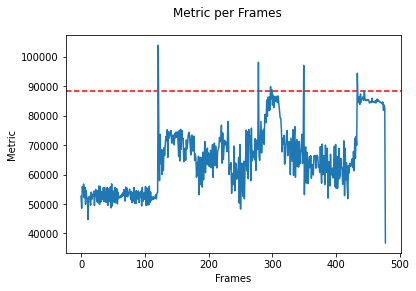

In [ ]:
main_frames_pixels = diff_pixel(filename,20,0.8)

### Diferenças entre Blocos
Os thresholds foram encontrados empiricamente.

Largura do video: 384
Altura do videps: 288
FPS: 30.0
Number of main frames: 4
Number of frames: 478


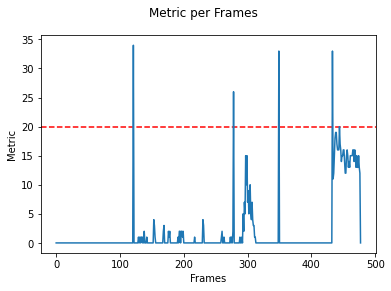

In [ ]:
main_frames_blocks = diff_blocos(filename,10,20)

### Diferenças entre Histogramas
É o único método com um threshold com fórmula,T = μ +ασ.

Onde μ é a média do vetor de diferenças entre histogramas e σ é o desvio padrão. O valor de α foi encontrado empiricamente.

Largura do video: 384
Altura do videps: 288
FPS: 30.0
Number of main frames: 6
Number of frames: 478


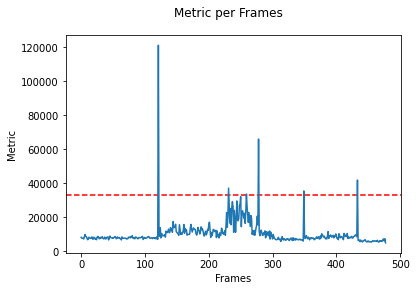

In [ ]:
main_frames_hist = diff_hist(filename)

### Diferenças entre Mapas de Borda
O threshold foi encontrado empiricamente.

Largura do video: 384
Altura do videps: 288
Número de Quadros do video: 30.0
Number of main frames: 7
Number of frames: 478


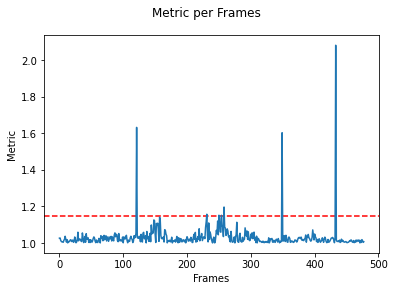

In [ ]:
main_frames_borda = diff_mapa_de_bordas(filename,1.15)

## Conclusões

Os gráficos dos quatro métodos foram parecidos, o mais dissoante é o gráfico da diferença de pixels pois a diferença de pixel é mais sensível a ruídos, outliers e transformações (rotações e translações). A sensibilidade à ruídos é melhorada com a diferença de blocos, pois é analisado região por região. Já os dois ultimos, são invariantes quanto a rotações e translações pois analisam parâmetros que não variam com essas transformações. Por fim, conclui-se que todos encontraram valores parecidos de quadros principais, porém, o método mais automático é a diferença de histogramas, pois o threshold é definido por uma fórmula.

## Teste com outros vídeos

Entre com um vídeo seu e refaça o experimento.

In [ ]:
filename_teste = 'neve.mp4'

Largura do video: 480
Altura do videps: 848
FPS: 30.0
Number of main frames: 46
Number of frames: 469


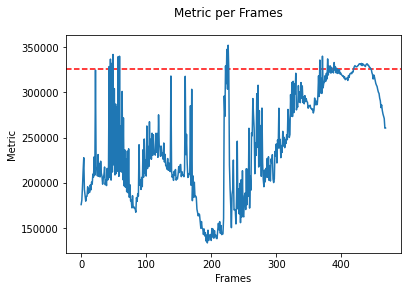

In [ ]:
main_frames_pixels = diff_pixel(filename_teste,5,0.8)

Largura do video: 480
Altura do videps: 848
FPS: 30.0
Number of main frames: 54
Number of frames: 469


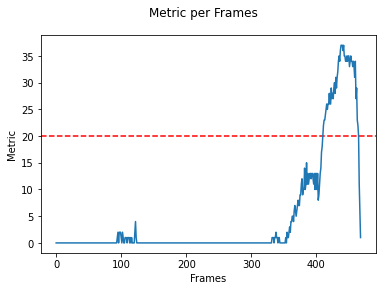

In [ ]:
main_frames_blocks = diff_blocos(filename_teste,10,20)

Largura do video: 480
Altura do videps: 848
FPS: 30.0
Number of main frames: 11
Number of frames: 469


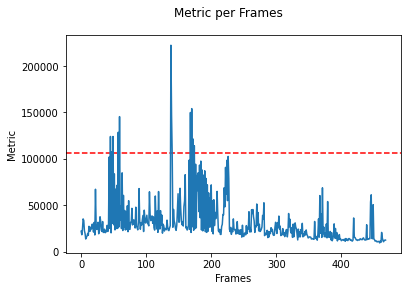

In [ ]:
main_frames_hist = diff_hist(filename_teste)

Largura do video: 480
Altura do videps: 848
Número de Quadros do video: 30.0
Number of main frames: 12
Number of frames: 469


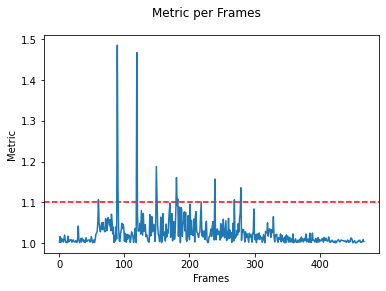

In [ ]:
main_frames_borda = diff_mapa_de_bordas(filename_teste,1.1)